# AP-based Denoising Pipeline (3D Monte Carlo Data)

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from tifffile import imread, imsave
import matplotlib.pyplot as plt

from gap import GAP3D
from BinomDatasetTime import BinomDataset3D

In [2]:
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# Load 3D time-resolved data: shape [C, T, D, H, W]
data = np.load("output/mcx_data_20250613_225804.npy")  # Replace with your path
print("Data shape:", data.shape)

Data shape: (3, 64, 60, 60, 60)


In [4]:
# Hyperparameters
minpsnr = -40
maxpsnr = -5
patch_size = 32
batch_size = 2
max_epochs = 100
checkpoint_dir = "./checkpoints_3d/"
model_name = f"gap3d-{minpsnr}to{maxpsnr}-patch{patch_size}"

In [5]:
# Prepare datasets
train_data = data[:, :, :48]  # D = 48
val_data = data[:, :, 16:48]  # D = 32

train_dataset = BinomDataset3D(train_data, patch_size=patch_size, minPSNR=minpsnr, maxPSNR=maxpsnr, virtSize=2000)
val_dataset = BinomDataset3D(val_data, patch_size=patch_size, minPSNR=minpsnr, maxPSNR=maxpsnr, virtSize=500)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Train dataset size: 2000
Validation dataset size: 500


Sample Shape:  torch.Size([6, 64, 32, 32, 32])


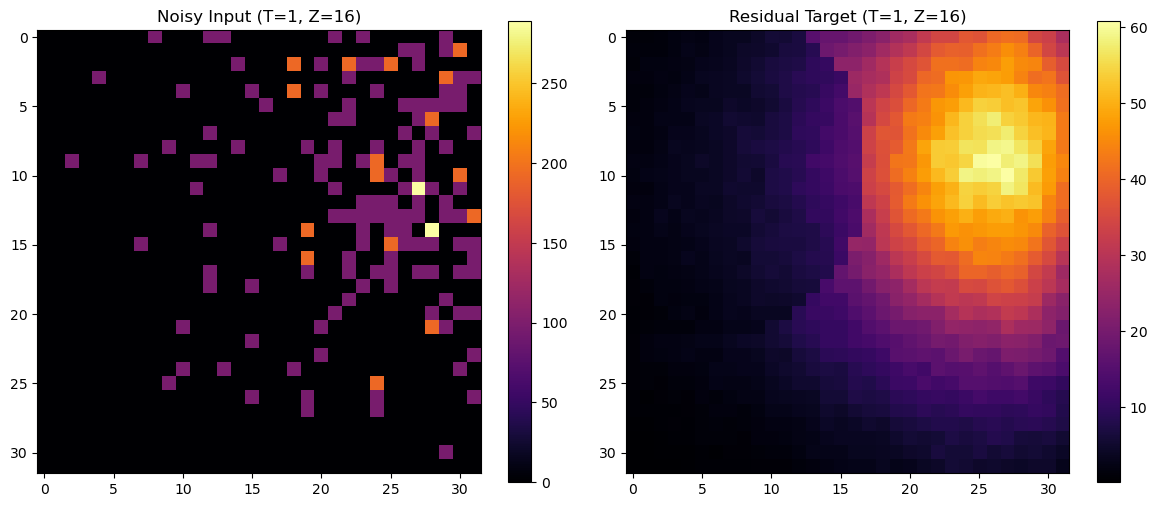

In [6]:
# Fetch a sample
sample = train_dataset[0]  # shape: [2C, T, D, H, W]
print("Sample Shape: ", sample.shape)

# Separate residual and noisy components
C = sample.shape[0] // 2
residual = sample[:C]
noisy = sample[C:]

# Select a voxel to visualize: fixed T and Z slices
time_idx = C // 2
depth_idx = sample.shape[2] // 2

# Plot a 2D slice of the noisy input and residual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(noisy[0, time_idx, depth_idx], cmap="inferno")
plt.title(f"Noisy Input (T={time_idx}, Z={depth_idx})")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(residual[0, time_idx, depth_idx], cmap="inferno")
plt.title(f"Residual Target (T={time_idx}, Z={depth_idx})")
plt.colorbar()

plt.tight_layout()
plt.show()

In [7]:
# Initialize model
model = GAP3D(levels=10, channels=3, depth=5, start_filts=32, merge_mode='add')

# Callbacks
checkpoint_cb = ModelCheckpoint(dirpath=checkpoint_dir, filename=model_name, monitor="val_loss", save_top_k=1, mode="min")
lr_monitor = LearningRateMonitor(logging_interval="epoch")
early_stop = EarlyStopping(monitor="val_loss", patience=20, mode="min")

# Trainer
trainer = pl.Trainer(
    default_root_dir=checkpoint_dir,
    max_epochs=max_epochs,
    devices=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_cb, lr_monitor, early_stop],
    gradient_clip_val=0.5,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
# Train
trainer.fit(model, train_loader, val_loader)

# Save final model
trainer.save_checkpoint(os.path.join(checkpoint_dir, f"{model_name}.ckpt"))


  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | down_convs | ModuleList | 23.6 M | train
1 | up_convs   | ModuleList | 8.4 M  | train
2 | conv_final | Conv3d     | 99     | train
--------------------------------------------------
32.0 M    Trainable params
0         Non-trainable params
32.0 M    Total params
128.120   Total estimated model params size (MB)
48        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Expected 4D (unbatched) or 5D (batched) input to conv3d, but got input of size: [2, 30, 64, 32, 32, 32]

In [ ]:
# Load and run inference
model = GAP3D.load_from_checkpoint(os.path.join(checkpoint_dir, f"{model_name}.ckpt")).to(device)
model.eval()

In [ ]:
# Example inference
sample = next(iter(val_loader))  # [B, 2C, T, D, H, W]
with torch.no_grad():
    pred = model(sample[:, 3:])  # Input: noisy half
    pred = torch.exp(pred)
    recon = sample[:, 3:] * pred / pred.sum(dim=(-1, -2, -3, -4), keepdim=True)

    plt.plot(pred[0, :, 32, 16, 16].cpu().numpy())
    plt.title("Predicted Histogram at [z=32, y=16, x=16]")
    plt.xlabel("Time Bin")
    plt.ylabel("Fluence")
    plt.grid(True)
    plt.show()

In [ ]:
# Save output tensor
np.save("output_denoised.npy", recon.cpu().numpy())